# **Reading Data and Processing using NLTK**

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [94]:
# Read in data
df = pd.read_csv('/kaggle/input/amazon/amazon_reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(4915, 12)
(500, 12)


In [97]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


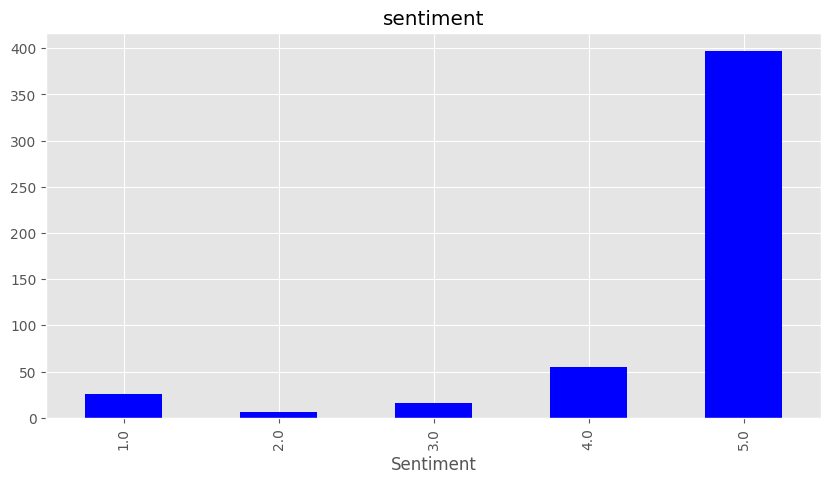

In [98]:
ax = df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='sentiment',
          figsize=(10, 5), color='blue')
ax.set_xlabel('Sentiment')
plt.show()

# **Basic NLTK**

In [99]:
example = df['reviewText'][50]
print(example)

A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.


In [100]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['A', 'memory', 'card', 'either', 'works', 'or', 'it', 'does', "n't", '.']

In [101]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('A', 'DT'),
 ('memory', 'NN'),
 ('card', 'NN'),
 ('either', 'CC'),
 ('works', 'VBZ'),
 ('or', 'CC'),
 ('it', 'PRP'),
 ('does', 'VBZ'),
 ("n't", 'RB'),
 ('.', '.')]

In [102]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  A/DT
  memory/NN
  card/NN
  either/CC
  works/VBZ
  or/CC
  it/PRP
  does/VBZ
  n't/RB
  ./.
  This/DT
  was/VBD
  always/RB
  going/VBG
  to/TO
  be/VB
  a/DT
  one/CD
  star/NN
  or/CC
  five/CD
  star/NN
  review/NN
  -/:
  no/DT
  middle/JJ
  ground.The/NN
  adapter/NN
  is/VBZ
  a/DT
  nice/JJ
  bonus/NN
  too/RB
  ,/,
  though/IN
  I/PRP
  do/VBP
  n't/RB
  think/VB
  I/PRP
  have/VBP
  anything/NN
  to/TO
  use/VB
  it/PRP
  with/IN
  ./.)


# **Roberta Pretrained Model**

In [103]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [104]:
MODEL = r"/kaggle/input/twitter-roberta/twitter_roberta"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at /kaggle/input/twitter-roberta/twitter_roberta were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [105]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.36422554, 'roberta_neu': 0.49493834, 'roberta_pos': 0.14083606}


In [110]:
# def polarity_scores_roberta(example):
#     encoded_text = tokenizer(example, return_tensors='pt')
#     output = model(**encoded_text)
#     scores = output[0][0].detach().numpy()
#     scores = softmax(scores)
#     scores_dict = {
#         'roberta_neg' : scores[0],
#         'roberta_neu' : scores[1],
#         'roberta_pos' : scores[2]
#     }
#     return scores_dict
def polarity_scores_roberta(example):
    # Check and convert to string if necessary
    if not isinstance(example, str):
        print(f"Invalid type: {type(example)}. Converting to string.")
        example = str(example)
    
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    return scores

In [111]:
from tqdm.notebook import tqdm

In [126]:
# res = {}
# for i, row in tqdm(df.iterrows(), total=len(df)):
#     try:
#         text = row['reviewText']
#         myid = row['Unnamed: 0']
#         roberta_result = polarity_scores_roberta(text)
#         res[myid] = roberta_result
#     except RuntimeError:
#         print(f'Broke for id {myid}')

res = {}
for idx, row in df.iterrows():
    try:
        text = row['reviewText']
        myid = row['Unnamed: 0']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError as e:
        print(f"Runtime error for ID {myid}: {e}")
    except ValueError as e:
        print(f"Value error for ID {myid}: {e}")
    except Exception as e:
        print(f"Unexpected error for ID {myid}: {e}")

Runtime error for ID 76: The expanded size of the tensor (1066) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1066].  Tensor sizes: [1, 514]
Runtime error for ID 123: The expanded size of the tensor (1167) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1167].  Tensor sizes: [1, 514]
Invalid type: <class 'float'>. Converting to string.


In [138]:
df

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,AtlantaNative,5.0,There's not much to be said for this except th...,2012-12-30,708,0,0,0,0,0.0,0.0
496,496,Atlashrggd,5.0,As an photographer I rely on high quality card...,2012-05-12,940,0,0,0,0,0.0,0.0
497,497,A to Z Guarantee,5.0,Been using it for a month and everything works...,2013-09-07,457,0,0,0,0,0.0,0.0
498,498,Audi A4B7,5.0,This is my 4th unit that I had purchased from ...,2014-01-31,311,0,0,0,0,0.0,0.0


In [142]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Unnamed: 0'})
results_df = results_df.merge(df, how='left')

In [145]:
results_df.columns

Index([          'Unnamed: 0',                      0,                      1,
                            2,         'reviewerName',              'overall',
                 'reviewText',           'reviewTime',             'day_diff',
                'helpful_yes',           'helpful_no',           'total_vote',
         'score_pos_neg_diff', 'score_average_rating',   'wilson_lower_bound'],
      dtype='object')

In [146]:
results_df

,Unnamed: 0,0,1,2,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,-1.544986,0.843202,0.173296,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,-2.450707,0.058892,2.409628,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,0.178447,0.534343,-0.992748,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,-2.329360,-0.345701,2.440746,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,-2.670925,0.185993,2.310832,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,495,-1.805596,-0.046560,1.703076,AtlantaNative,5.0,There's not much to be said for this except th...,2012-12-30,708,0,0,0,0,0.0,0.0
494,496,-2.221357,-0.299200,2.335850,Atlashrggd,5.0,As an photographer I rely on high quality card...,2012-05-12,940,0,0,0,0,0.0,0.0
495,497,-2.301410,0.305489,1.758549,A to Z Guarantee,5.0,Been using it for a month and everything works...,2013-09-07,457,0,0,0,0,0.0,0.0
496,498,-2.935261,0.230224,2.831196,Audi A4B7,5.0,This is my 4th unit that I had purchased from ...,2014-01-31,311,0,0,0,0,0.0,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

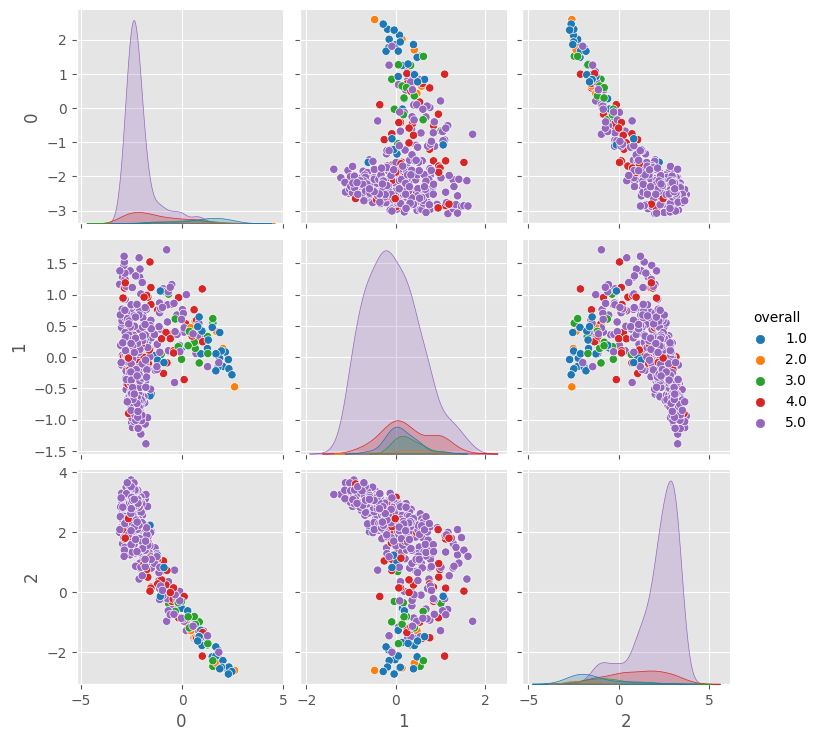

In [148]:
sns.pairplot(data=results_df,
             vars=[0, 1, 2],
            hue='overall',
            palette='tab10')
plt.show()